**결정 트리로 분류, 회귀를 훈련하고 시각화, 예측, 튜닝을 수행한다.**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

# 깔끔한 그래프 출력을 위해
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print(f"그림 저장: {fig_id}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 결정 트리 학습과 시각화

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:]  # 꽃잎 길이와 너비
y = iris.target
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

**<붓꽃 결정 트리>**

그림 저장: iris_tree


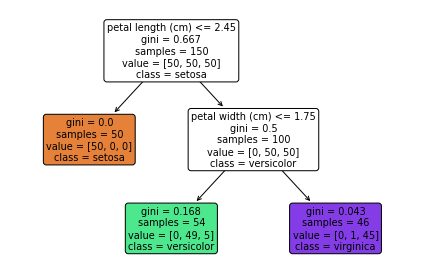

In [3]:
from sklearn.tree import plot_tree

plot_tree(tree_clf, feature_names=iris.feature_names[2:], class_names=iris.target_names, rounded=True, filled=True)
save_fig("iris_tree")

# 예측하기

**지니 불순도**

$
G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}
$

**엔트로피 불순도**

$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$


**분류에 대한 CART 비용 함수**

$
\begin{split}
&J(k, t_k) = \dfrac{m_{\text{left}}}{m}G_\text{left} + \dfrac{m_{\text{right}}}{m}G_{\text{right}}\\
&\text{여기에서 }\begin{cases}
G_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 불순도}\\
m_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 샘플 수}
\end{cases}
\end{split}
$

**<결정 트리의 결정 경계>**

그림 저장: decision_tree_decision_boundaries_plot


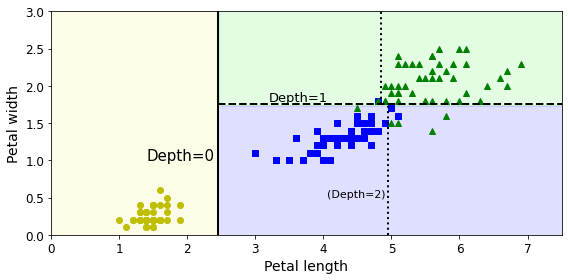

In [4]:
import numpy as np
from matplotlib.colors import ListedColormap


def plot_decision_boundary(clf, X, y, axes=None, iris=True, legend=False, plot_training=True):
    if axes is None:
        axes = [0, 7.5, 0, 3]
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(["#7d7d58", "#4c4c7f", "#507d50"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y == 2], X[:, 1][y == 2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)


plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)
save_fig("decision_tree_decision_boundaries_plot")
plt.show()

# 클래스 확률 추정

In [5]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])

# 규제 매개변수

(회전 같은) 데이터셋의 작은 변화가 매우 다른 결정 트리를 만든다. 사이킷런에서 사용하는 CART 훈련 알고리즘은 확률적이기 때문에 동일한 데이터에서 같은 모델을 훈련하여 매번 매우 다른 모델을 만들 수 있다. 이를 확인하기 위해 `random_state`를 다른 값으로 지정해 보겠다:

In [7]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=40)

**<훈련 세트의 세부사항에 민감한 결정 트리>**

그림 저장: decision_tree_instability_plot


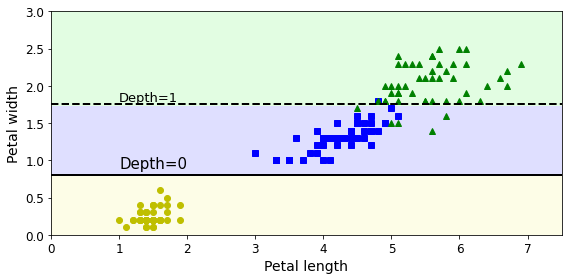

In [8]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X, y, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)
save_fig("decision_tree_instability_plot")
plt.show()

**<min_samples_leaf 매개변수를 사용한 규제>**

데이터셋을 회전하면 완전히 다른 결정 경계를 만든다:

그림 저장: min_samples_leaf_plot


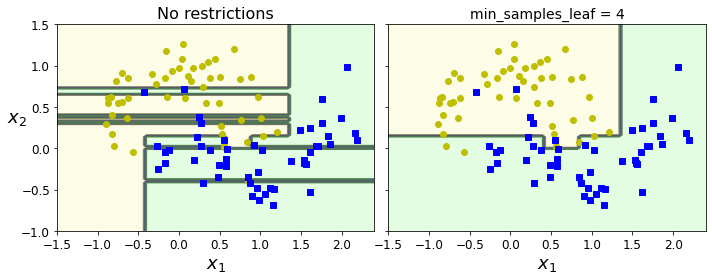

In [9]:
from sklearn.datasets import make_moons

Xm, ym = make_moons(noise=0.25)
deep_tree_clf1 = DecisionTreeClassifier()
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title(f"min_samples_leaf = {deep_tree_clf2.min_samples_leaf}", fontsize=14)
plt.ylabel('')
save_fig("min_samples_leaf_plot")
plt.show()

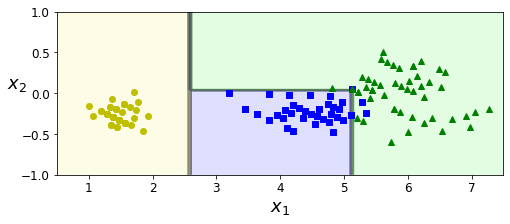

In [10]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)
tree_clf_r = DecisionTreeClassifier()
tree_clf_r.fit(Xr, y)
plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)
plt.show()

**<훈련 세트의 회전에 민감한 결정 트리>**

그림 저장: sensitivity_to_rotation_plot


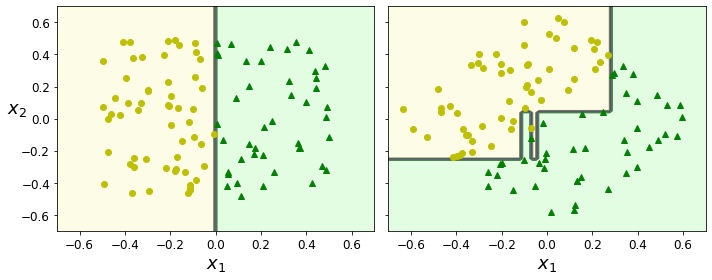

In [11]:
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2
angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)
tree_clf_s = DecisionTreeClassifier()
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier()
tree_clf_sr.fit(Xsr, ys)
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel('')
save_fig("sensitivity_to_rotation_plot")
plt.show()

# 회귀

간단한 선형 데이터셋을 준비한다:

In [12]:
# 2차식으로 만든 데이터셋 + 잡음
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

**<두 개의 결정 트리 회귀 모델의 예측>**

그림 저장: tree_regression_plot


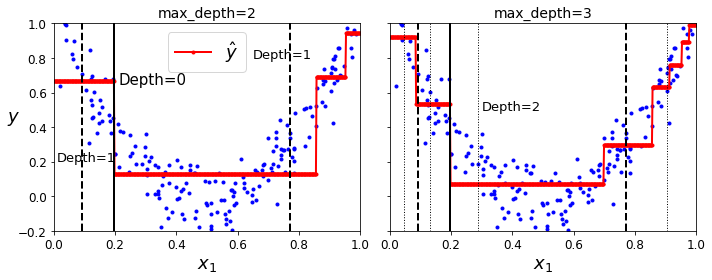

In [14]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg2 = DecisionTreeRegressor(max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)


def plot_regression_predictions(tree_reg, X, y, axes=None, ylabel="$y$"):
    if axes is None:
        axes = [0, 1, -0.2, 1]
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")


fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)
plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel='')
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)
save_fig("tree_regression_plot")
plt.show()

**<회귀 결정 트리>**

그림 저장: regression_tree


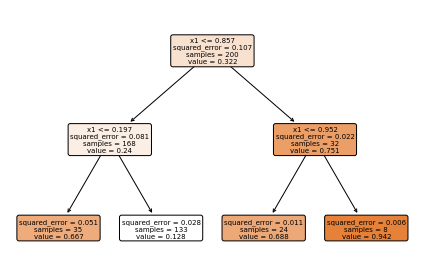

In [15]:
plot_tree(tree_reg1, feature_names=["x1"], rounded=True, filled=True)
save_fig("regression_tree")

**<결정 트리 회귀 모델의 규제>**

그림 저장: tree_regression_regularization_plot


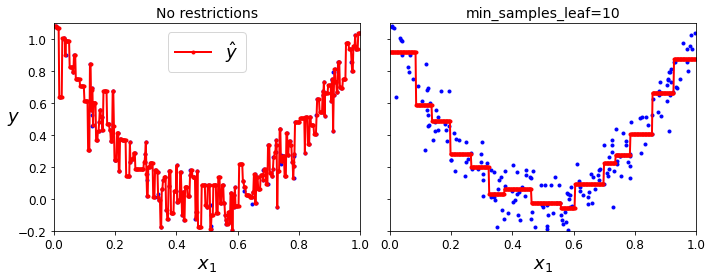

In [16]:
tree_reg1 = DecisionTreeRegressor()
tree_reg2 = DecisionTreeRegressor(min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)
x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)
plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}", fontsize=14)
save_fig("tree_regression_regularization_plot")
plt.show()

# 연습

## 1.

_moons 데이터셋에 결정 트리를 훈련시키고 세밀하게 튜닝해 보자._

a. `make_moons(n_samples=1000, noise=0.4)`를 사용해 데이터셋을 생성한다.

In [17]:
X, y = make_moons(n_samples=10000, noise=0.4)

b. 이를 `train_test_split()`을 사용해 훈련 세트와 테스트 세트로 나눈다.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

c. `DecisionTreeClassifier`의 최적의 매개변수를 찾기 위해 교차 검증과 함께 그리드 탐색을 수행한다(`GridSearchCV`를 사용한다).

In [19]:
from sklearn.model_selection import GridSearchCV

params = {"max_leaf_nodes": list(range(2, 100)), "min_samples_split": [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(), params, verbose=1, cv=3, n_jobs=-1)
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [20]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=18)

d. 찾은 매개변수를 사용해 전체 훈련 세트에 대해 모델을 훈련시키고 테스트 세트에서 성능을 측정한다. 대략 86%의 정확도가 나올 것이다.

기본적으로 `GridSearchCV`는 전체 훈련 세트로 찾은 최적의 모델을 다시 훈련시킨다(`refit=False`로 지정해서 바꿀 수 있다). 그래서 별도로 작업할 필요가 없다. 모델의 정확도를 바로 평가할 수 있다:

In [21]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8565

## 2.

_랜덤 포레스트를 만들어 보자._

a. 이전 연습에 이어서, 훈련 세트의 서브셋을 1,000개 생성한다. 각각은 무작위로 선택된 100개의 샘플을 담고 있다. 사이킷런의 `ShuffleSplit`을 사용할 수 있다.

In [22]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100
mini_sets = []
rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

b. 앞에서 찾은 최적의 매개변수를 사용해 각 서브셋에 결정 트리를 훈련시킨다. 테스트 세트로 이 1,000개의 결정 트리를 평가한다. 더 작은 데이터셋에서 훈련되었기 때문에 이 결정 트리는 앞서 만든 결정 트리보다 성능이 떨어져 약 79%의 정확도를 낸다.

In [23]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]
accuracy_scores = []
for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
np.mean(accuracy_scores)

0.7898440000000001

c. 이제 마술을 부릴 차례이다. 각 테스트 세트 샘플에 대해 1,000개의 결정 트리 예측을 만들고 다수로 나온 예측만 취한다(사이파이의 `mode()` 함수를 사용할 수 있다). 그러면 테스트 세트에 대한 _다수결 예측_ 이 만들어진다.

In [24]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)
for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [25]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred)

d. 테스트 세트에서 이 예측을 평가한다. 앞서 만든 모델보다 조금 높은(약 6.8% 정도) 정확도를 얻게 될 것이다. 랜덤 포레스트 분류기를 훈련시켰다!

In [26]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.858